In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

In [2]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams['figure.dpi'] = 500

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
nbar = 0.001
cosmology=fiducial.AbacusSummitBase()
z = 1.175
bias = 1.8

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Initialize Gaussian model

In [4]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=bias, nbar=nbar)

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/main/lib/python3.9/site-packages/cosmoprimo/interpolator.py:517: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


## Compute density split CCFs (tracers-tracers)

In [11]:
model.compute_delta2_tilde(density_bins=density_bins, shot_noise=True, p=4)

array([0.66780132, 0.01576018, 0.95479781])

In [12]:
density_bins = np.array([-np.inf, -0.21875857,  0.21875857, np.inf])
ccf_tracers = model.ccf_tracers(density_bins=density_bins)
ccf_tracers_with_shot_noise = model.ccf_tracers(density_bins=density_bins, shot_noise=True, p=4)

IndexError: invalid index to scalar variable.

In [15]:
res = list()

xi_R = model.xi_R_with_shot_noise
sigma_R = model.sigma_R_with_shot_noise
sigma_RR = np.sqrt(model.density_moments[1]-1)
split_delta_tilde = model.compute_delta_tilde(density_bins, True, p=4)
split_delta2_tilde = model.compute_delta2_tilde(density_bins, True, p=4)

for i in range(len(density_bins) - 1):
    denom = 1 + sigma_R**2 * split_delta_tilde[i] / sigma_RR**2
    num = model.xi + xi_R / sigma_RR**2 * (split_delta_tilde[i] - sigma_R**2 + sigma_R**2 * split_delta2_tilde[i] / sigma_RR**2)
    res.append(num/denom)


[000740.86]  12-15 12:02  matplotlib.mathtext          INFO     Substituting symbol \ell from STIXGeneral
[000740.87]  12-15 12:02  matplotlib.mathtext          INFO     Substituting symbol \ell from STIXGeneral
[000741.03]  12-15 12:02  matplotlib.mathtext          INFO     Substituting symbol \ell from STIXGeneral
[000741.04]  12-15 12:02  matplotlib.mathtext          INFO     Substituting symbol \ell from STIXGeneral


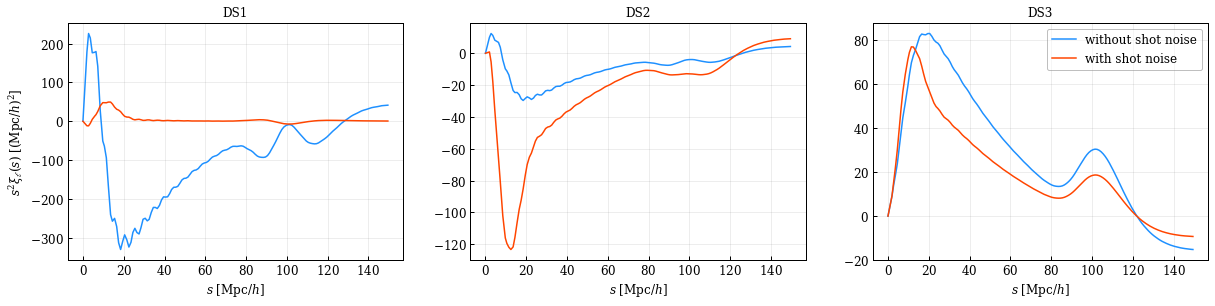

In [17]:
plt.rcParams["figure.figsize"] = (18, 4)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_tracers[i], label='without shot noise')
    axes[i].plot(sep, sep**2 * res[i], label='with shot noise')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.show()

## Behaviour of $\xi_R^{DS}$

In [18]:
def f(x, y, sigma_R, sigma_RR, xi, xi_R):
    denom = 1 + sigma_R**2 * x / sigma_RR**2
    num = xi + xi_R / sigma_RR**2 * (x - sigma_R**2 + sigma_R**2 * y / sigma_RR**2)
    return num, denom, num/denom

In [67]:
model.sep[100]

array([100.52248028])

In [68]:
idx=100

In [69]:
size = 300
vals_num = np.ndarray(shape=(size, size))
vals_denom = np.ndarray(shape=(size, size))
vals_ratio = np.ndarray(shape=(size, size))
delta1 = np.linspace(-2, 2, size)
delta2 = np.linspace(-2, 2, size)

for i in range(size):
    for j in range(size):
        x = delta1[i]
        y = delta2[j]
        num, denom, ratio = f(x, y, model.sigma_R, model.sigma_RR, model.xi[idx], model.xi_R[idx])
        vals_num[i][j] = num.real
        vals_denom[i][j] = denom.real
        vals_ratio[i][j] = 1/ratio.real

In [70]:
th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)

In [71]:
plt.rcParams['figure.dpi'] = 500

/tmp/ipykernel_2965555/2965627492.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(c, ax=ax, label=r'$1 / \xi_{R}^{DS}$')


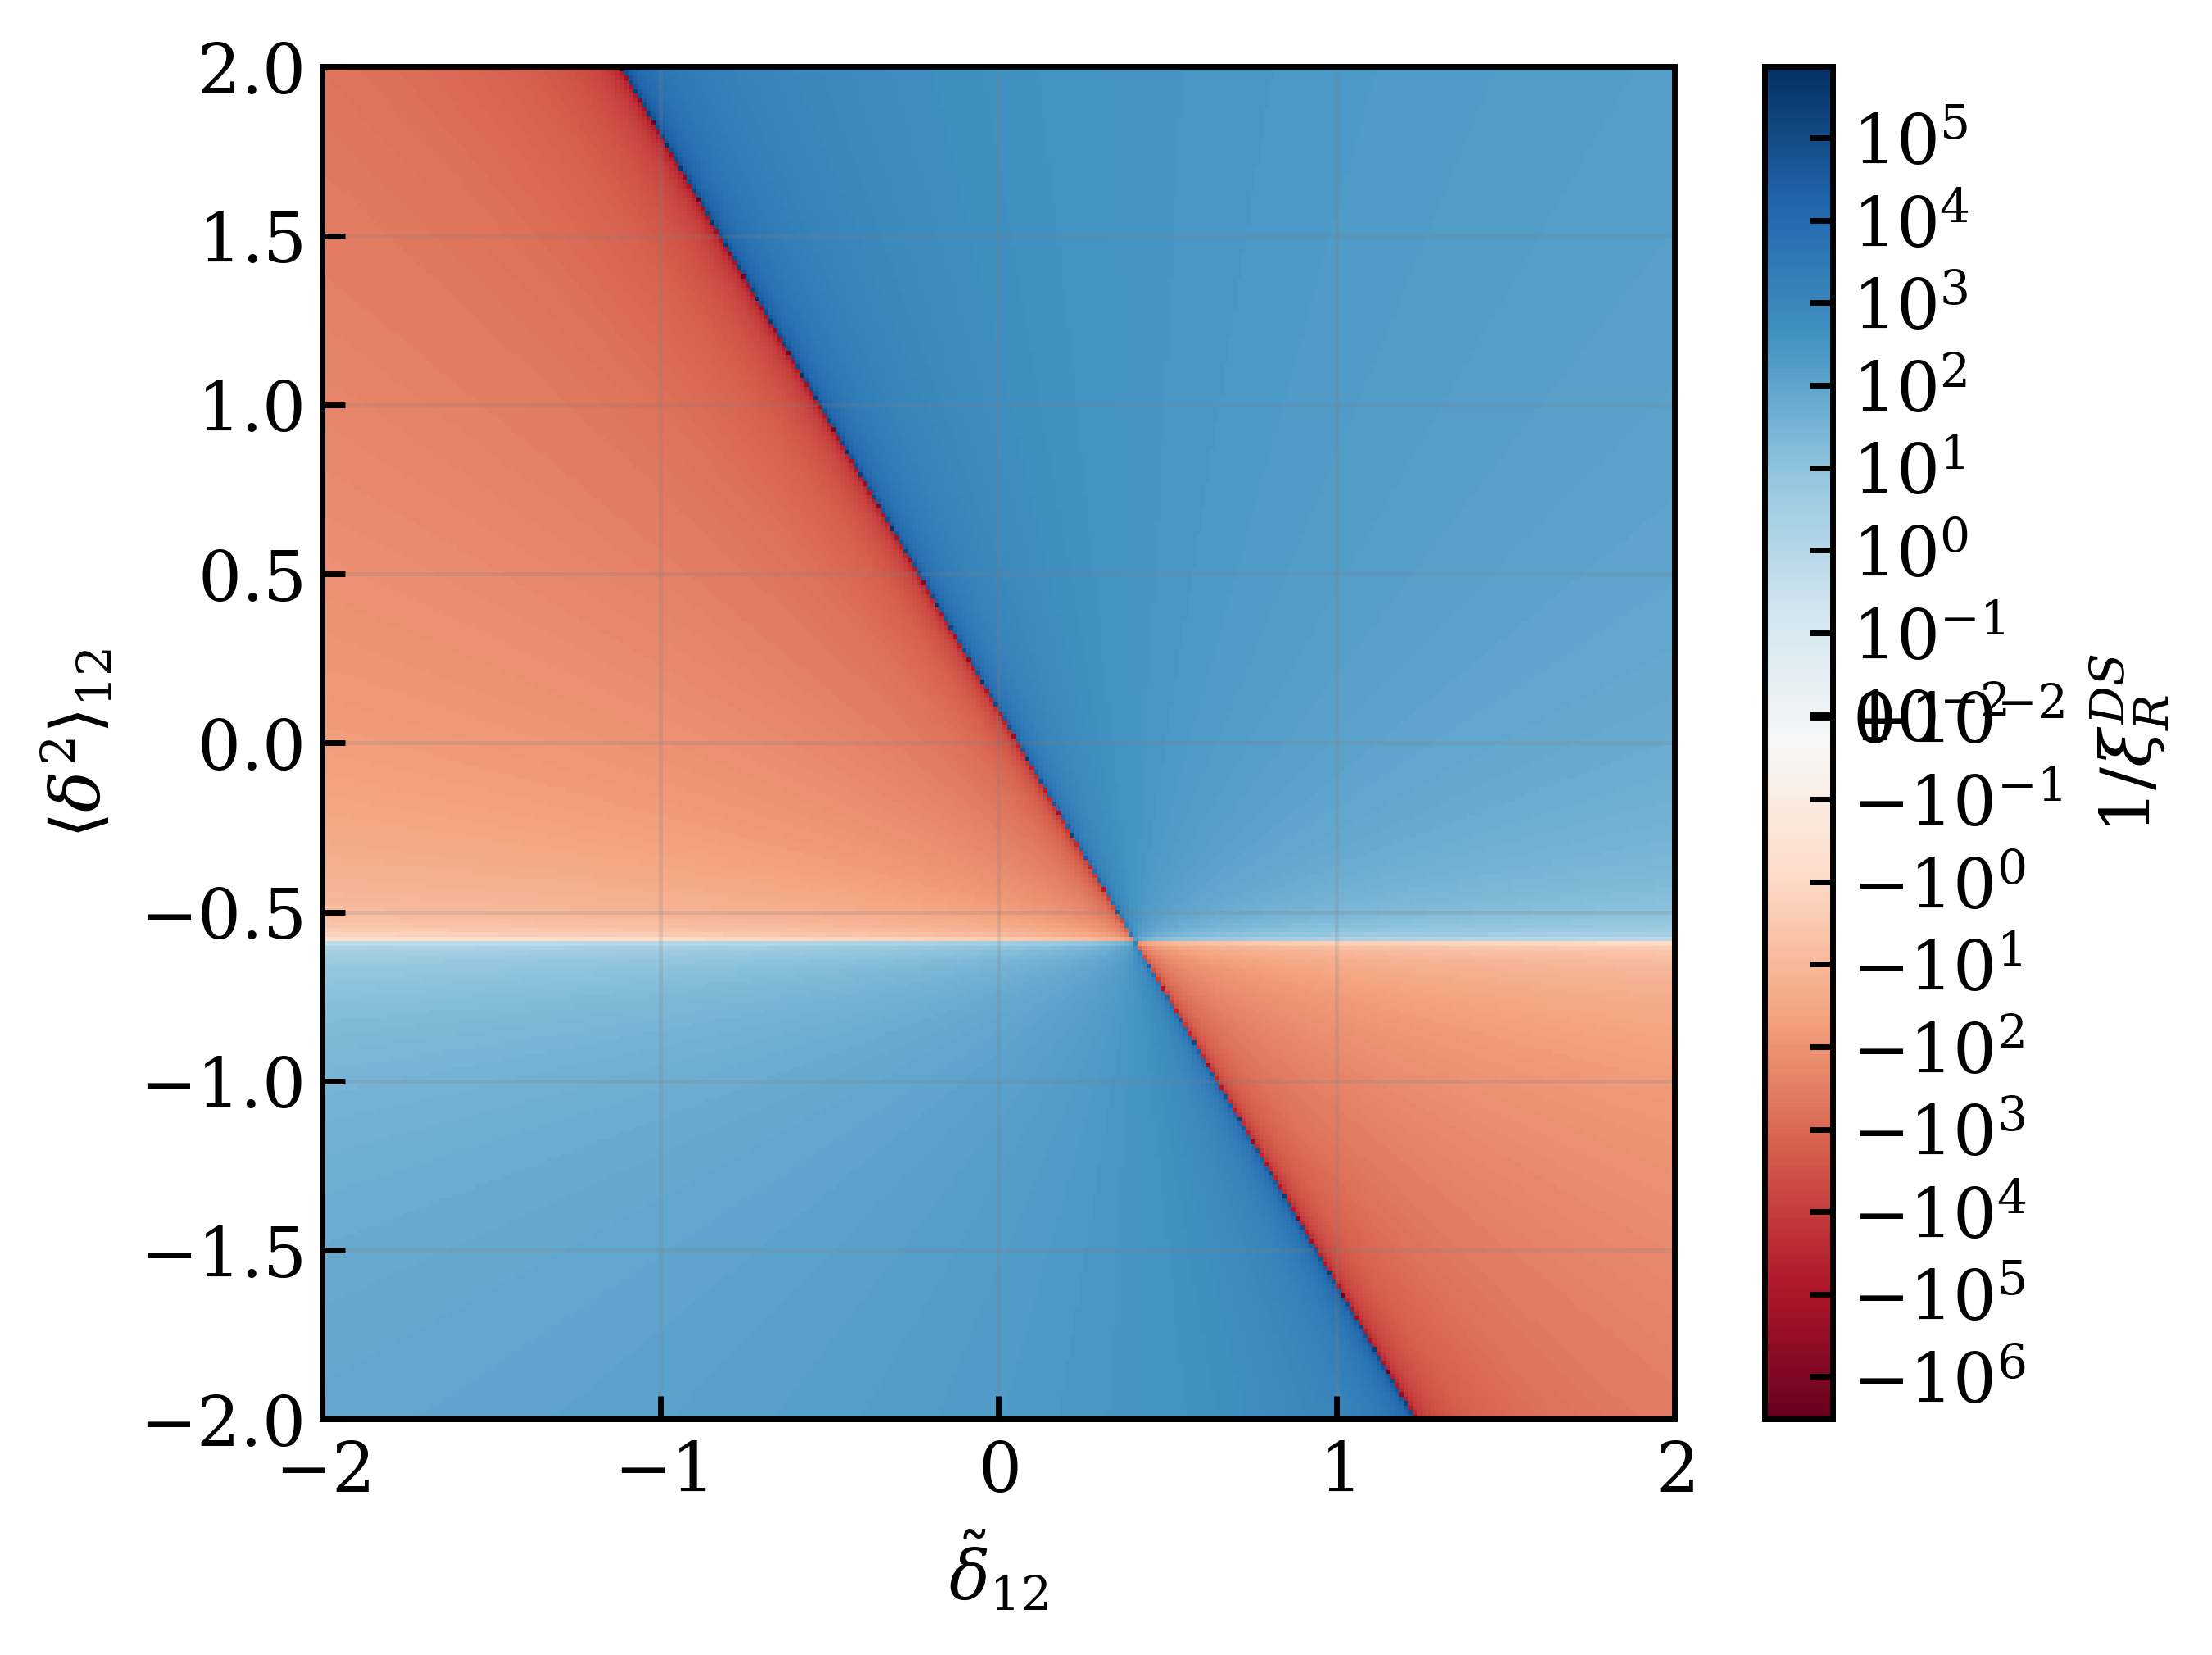

In [72]:
fig = plt.figure(figsize=(5, 4))

ax = plt.gca()

from matplotlib.colors import SymLogNorm, Normalize
#normalize = Normalize(vmin=np.min(vals), vmax=np.max(vals))
normalize = SymLogNorm(linthresh=0.01, linscale=0.01, vmin=np.min(vals_ratio), vmax=np.max(vals_ratio), base=10)
cmap = plt.get_cmap('RdBu')
extent = np.min(delta1), np.max(delta1), np.min(delta2), np.max(delta2)
c = ax.imshow(vals_ratio, cmap=cmap, norm=normalize, extent=extent, origin='lower')

ax.set_xlabel(r'$\tilde{\delta}_{12}$')
ax.set_ylabel(r'$\langle \delta^2 \rangle_{12}$')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, label=r'$1 / \xi_{R}^{DS}$')

plt.show()